# Lecture 4
### Peru (BCRPData API)
- **FX**: Interbank USD/PEN (buy) vs SBS banking system USD/PEN (buy)
- **Commodities**: Gold and Copper reference prices (daily series published by BCRP)

### USA (Yahoo Finance via `yfinance`)
- **Market**: SPY (US equities), TLT (US long bonds), GLD (gold ETF)

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [45]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

## 0) Load real financial data

If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [46]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()


Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


## 1) Quantities

### Exercise 1.1 — FX level comparison (Peru)

**Tasks**
1. Filter `peru` to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (`date` as index).
3. Plot both FX levels in the same line chart.
4. Create `spread = sbs - interbank` and plot it in a separate figure.

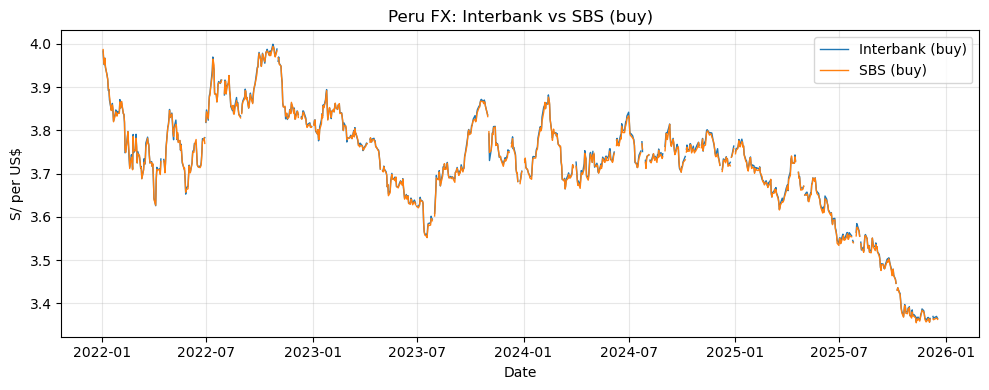

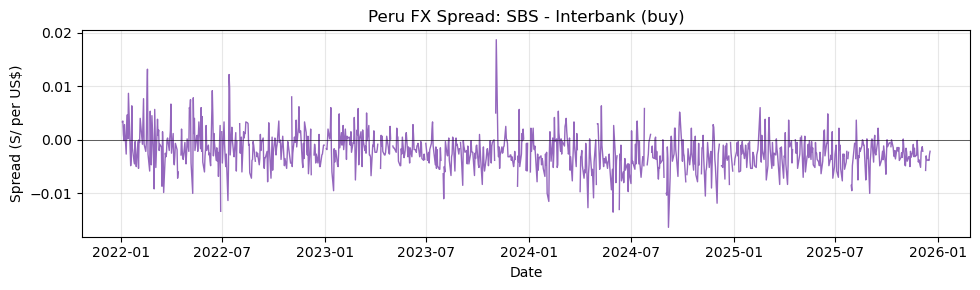

In [47]:
# Exercise 1.1 — FX level comparison (Peru)
# Uses existing variables: `peru`, `peru_wide`, `rename_map`

# 1) Filter peru to the two FX series (Interbank buy and SBS buy)
fx_keys = [k for k, v in rename_map.items() if v in {"fx_interbank_buy", "fx_sbs_buy"}]
fx_long = peru[peru["series_name"].isin(fx_keys)].copy()

# 2) Pivot to wide format (date as index) and rename to short names
fx_wide = (
    fx_long.pivot(index="date", columns="series_name", values="value")
    .rename(columns=rename_map)
    .reset_index()
    .sort_values("date")
)

# If pivot produced missing columns, try to use existing peru_wide as fallback
needed_cols = {"fx_interbank_buy", "fx_sbs_buy"}
if not needed_cols.issubset(set(fx_wide.columns)):
    fx_wide = peru_wide[["date", "fx_interbank_buy", "fx_sbs_buy"]].copy()

# 3) Plot both FX levels in the same line chart
plt.figure(figsize=(10, 4))
plt.plot(fx_wide["date"], fx_wide["fx_interbank_buy"], label="Interbank (buy)", linewidth=1)
plt.plot(fx_wide["date"], fx_wide["fx_sbs_buy"], label="SBS (buy)", linewidth=1)
plt.title("Peru FX: Interbank vs SBS (buy)")
plt.ylabel("S/ per US$")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Create spread = sbs - interbank and plot it in a separate figure
fx_wide["spread"] = fx_wide["fx_sbs_buy"] - fx_wide["fx_interbank_buy"]

plt.figure(figsize=(10, 3))
plt.plot(fx_wide["date"], fx_wide["spread"], color="tab:purple", linewidth=1)
plt.axhline(0, color="black", linewidth=0.7, alpha=0.6)
plt.title("Peru FX Spread: SBS - Interbank (buy)")
plt.ylabel("Spread (S/ per US$)")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2) Proportions

### Exercise 2.1 — Share of positive-return days (USA)

Define a positive day as `ret > 0`.

**Tasks**
1. For each ticker in `usa`, compute the share of days with `ret > 0`.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

  ticker  share_positive
0    GLD        0.545821
1    SPY        0.535750
2    TLT        0.493454


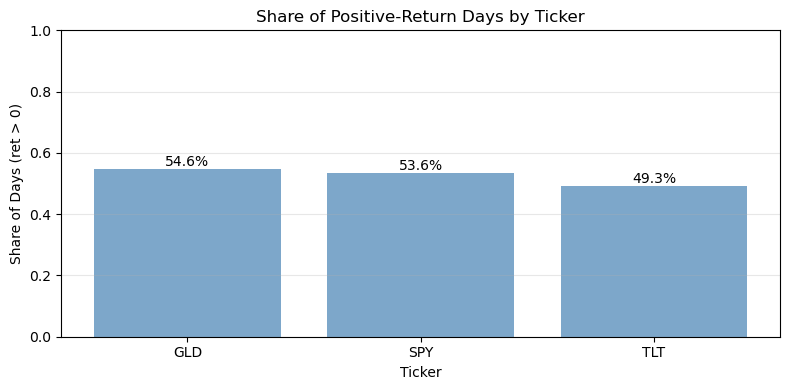

In [48]:
# Exercise 2.1 — Share of positive-return days (USA)

# 1) For each ticker in `usa`, compute the share of days with ret > 0
share_positive = usa.dropna(subset=['ret']).groupby('ticker').apply(
    lambda x: (x['ret'] > 0).sum() / len(x)
).reset_index()
share_positive.columns = ['ticker', 'share_positive']

print(share_positive)

# 2) Plot a bar chart of these shares
plt.figure(figsize=(8, 4))
bars = plt.bar(share_positive['ticker'], share_positive['share_positive'], color='steelblue', alpha=0.7)
plt.title('Share of Positive-Return Days by Ticker')
plt.ylabel('Share of Days (ret > 0)')
plt.xlabel('Ticker')
plt.ylim(0, 1)

# 3) Add labels (percent format) and a title
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3) Distributions

### Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF

**Goal:** compare distributions of a **Peru gold reference price** series vs the **US gold ETF (GLD)**.

**Tasks**
1. From `peru`, build a daily gold series and compute returns.
2. From `usa`, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

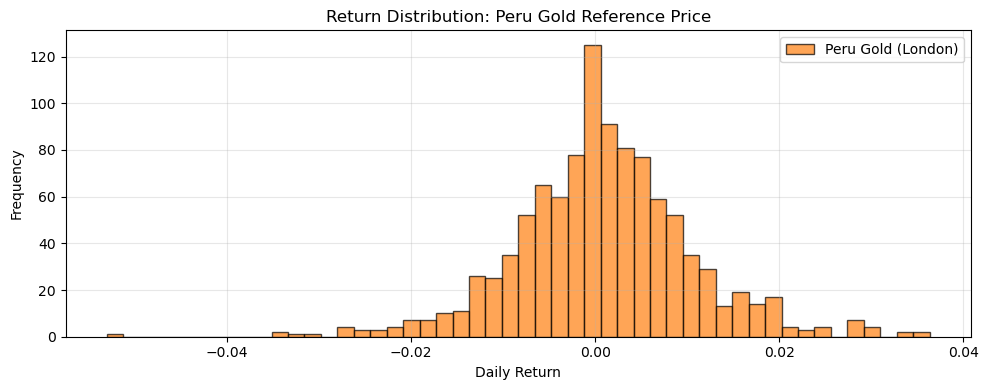

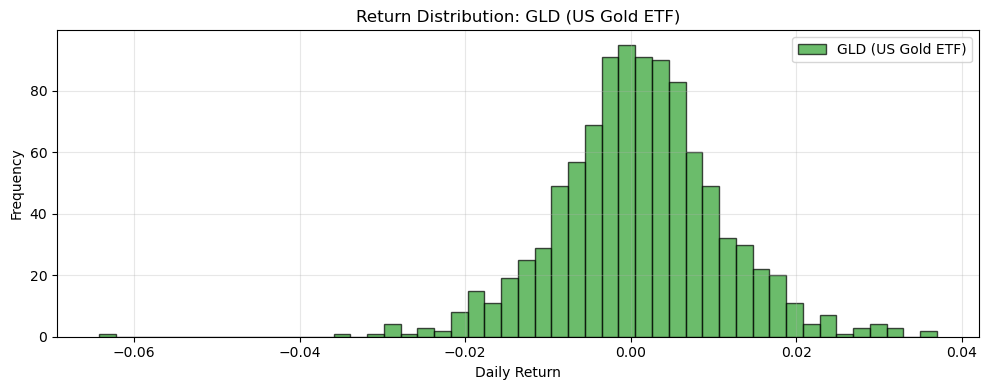

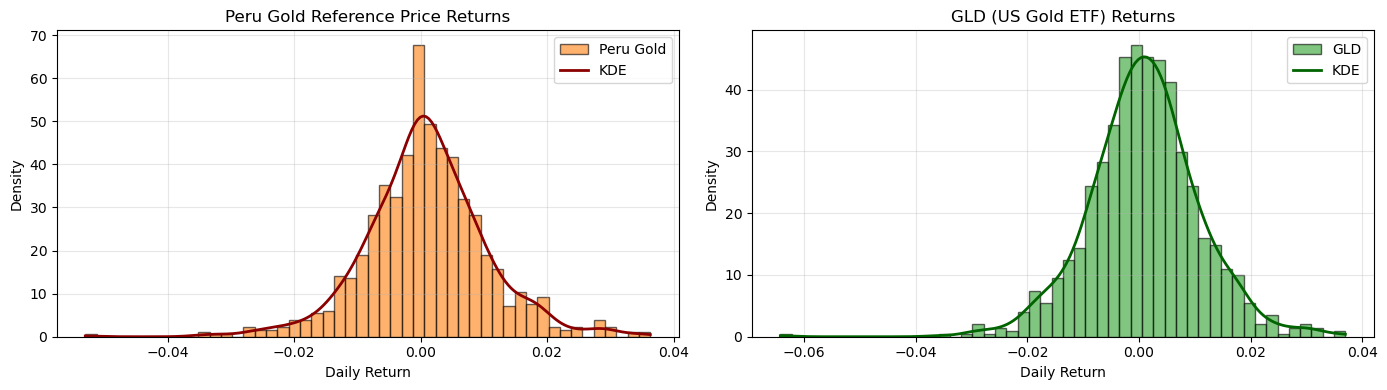

In [49]:
from scipy import stats

# Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF

# 1) From peru, build a daily gold series and compute returns
peru_gold = peru_wide[['date', 'gold_london']].copy()
peru_gold.columns = ['date', 'value']
peru_gold = peru_gold.sort_values('date').reset_index(drop=True)
peru_gold['gold_ret'] = pct_change(peru_gold['value'])

# 2) From usa, filter to GLD returns
gld_data = usa[usa['ticker'] == 'GLD'].copy().sort_values('date').reset_index(drop=True)

# 3) Plot two histograms (separate figures) with the same binning
bins = 50

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(peru_gold['gold_ret'].dropna(), bins=bins, alpha=0.7, color='tab:orange', label='Peru Gold (London)', edgecolor='black')
ax.set_title('Return Distribution: Peru Gold Reference Price')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(gld_data['ret'].dropna(), bins=bins, alpha=0.7, color='tab:green', label='GLD (US Gold ETF)', edgecolor='black')
ax.set_title('Return Distribution: GLD (US Gold ETF)')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Optional: overlay KDE for each distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Peru Gold
peru_ret_clean = peru_gold['gold_ret'].dropna()
ax1.hist(peru_ret_clean, bins=bins, alpha=0.6, color='tab:orange', label='Peru Gold', density=True, edgecolor='black')
if len(peru_ret_clean) > 1:
    kde_peru = stats.gaussian_kde(peru_ret_clean)
    x_range = np.linspace(peru_ret_clean.min(), peru_ret_clean.max(), 200)
    ax1.plot(x_range, kde_peru(x_range), color='darkred', linewidth=2, label='KDE')
ax1.set_title('Peru Gold Reference Price Returns')
ax1.set_xlabel('Daily Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(alpha=0.3)

# GLD
gld_ret_clean = gld_data['ret'].dropna()
ax2.hist(gld_ret_clean, bins=bins, alpha=0.6, color='tab:green', label='GLD', density=True, edgecolor='black')
if len(gld_ret_clean) > 1:
    kde_gld = stats.gaussian_kde(gld_ret_clean)
    x_range = np.linspace(gld_ret_clean.min(), gld_ret_clean.max(), 200)
    ax2.plot(x_range, kde_gld(x_range), color='darkgreen', linewidth=2, label='KDE')
ax2.set_title('GLD (US Gold ETF) Returns')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4) Relationships

### Exercise 4.1 — FX changes vs market returns (Peru + USA)

Use:
- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)

**Tasks**
1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from `usa`.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

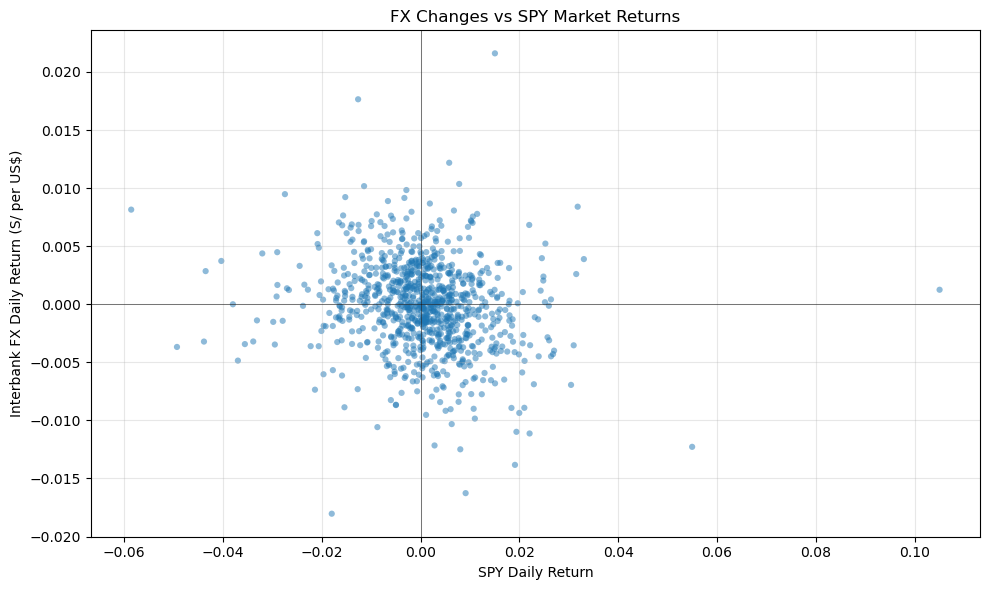

Correlation (SPY ret vs FX ret): -0.1781

Interpretation:
The correlation of -0.1781 suggests a negative relationship between SPY and FX returns.
The relationship is weak, indicating that US market movements have limited direct influence on Peru's FX rate.


In [50]:
# Exercise 4.1 — FX changes vs market returns (Peru + USA)
# Uses existing variables: `fx_wide`, `usa`

# 1) Build interbank FX daily returns from the Peru FX series
fx_wide_sorted = fx_wide.sort_values('date').reset_index(drop=True)
fx_wide_sorted['fx_ret'] = pct_change(fx_wide_sorted['fx_interbank_buy'])

# 2) Build SPY daily returns from `usa`
spy_data = usa[usa['ticker'] == 'SPY'].copy().sort_values('date').reset_index(drop=True)

# 3) Merge on date
merged = fx_wide_sorted[['date', 'fx_ret']].merge(
    spy_data[['date', 'ret']].rename(columns={'ret': 'spy_ret'}),
    on='date',
    how='inner'
).dropna(subset=['fx_ret', 'spy_ret'])

# 4) Scatter plot (x = SPY ret, y = FX ret)
plt.figure(figsize=(10, 6))
plt.scatter(merged['spy_ret'], merged['fx_ret'], alpha=0.5, s=20, edgecolor='none')
plt.xlabel('SPY Daily Return')
plt.ylabel('Interbank FX Daily Return (S/ per US$)')
plt.title('FX Changes vs SPY Market Returns')
plt.axhline(0, color='black', linewidth=0.7, alpha=0.5)
plt.axvline(0, color='black', linewidth=0.7, alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Compute correlation and interpret
corr = merged['spy_ret'].corr(merged['fx_ret'])
print(f"Correlation (SPY ret vs FX ret): {corr:.4f}")

# Interpretation
print(f"\nInterpretation:")
print(f"The correlation of {corr:.4f} suggests a {'positive' if corr > 0 else 'negative'} relationship between SPY and FX returns.")
if abs(corr) < 0.2:
    print(f"The relationship is weak, indicating that US market movements have limited direct influence on Peru's FX rate.")
elif abs(corr) < 0.5:
    print(f"The relationship is moderate, suggesting some co-movement between US equities and the Sol/Dollar exchange rate.")
else:
    print(f"The relationship is strong, indicating that US market performance significantly drives FX movements in Peru.")

## 5) References 

- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

## 2) Online Data Sources 

### Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will **inspect** what is being requested.

**Tasks**
1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using `http_get_text` and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [51]:
from pathlib import Path
import time
import requests

def fetch_text_with_session(url: str, timeout: int = 30, tries: int = 3) -> str:
    """Fetch raw text using a requests.Session (cookies) + browser-like headers."""
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9,es;q=0.8",
        "Referer": "https://estadisticas.bcrp.gob.pe/",
        "Connection": "keep-alive",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    }

    s = requests.Session()

    # Warm-up request to get cookies (can help with WAF/403)
    try:
        s.get("https://estadisticas.bcrp.gob.pe/", headers=headers, timeout=timeout)
    except Exception:
        pass

    last = None
    for k in range(tries):
        try:
            r = s.get(url, headers=headers, timeout=timeout)
            if r.status_code == 403:
                last = requests.HTTPError(f"403 Forbidden for url: {url}")
                time.sleep(1.5 * (k + 1))
                continue
            r.raise_for_status()
            return r.text
        except Exception as e:
            last = e
            time.sleep(1.5 * (k + 1))

    raise last


SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"

# 1) Recreate the API URL string used to download the Peru series
codes = "-".join(SERIES)
url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print("BCRPData URL (multi-series):")
print(url_multi)

# 2-3) Try to download raw CSV text and show first 10 lines
txt = None
raw_source = None

try:
    txt = fetch_text_with_session(url_multi, timeout=30, tries=3)
    raw_source = "server (multi-series)"
except Exception as e:
    print(f"[BCRP] Multi-series request failed: {type(e).__name__}: {e}")

# Fallback: try only ONE series (often allowed even if multi is blocked)
if txt is None:
    one = SERIES[0]
    url_one = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{one}/csv/{START_D}/{END_D}/{LANG}"
    print("\nBCRPData URL (single-series fallback):")
    print(url_one)
    try:
        txt = fetch_text_with_session(url_one, timeout=30, tries=3)
        raw_source = f"server (single-series: {one})"
    except Exception as e:
        print(f"[BCRP] Single-series request failed: {type(e).__name__}: {e}")

if txt is not None:
    # Replace <br> HTML tags with newline characters (some responses use HTML breaks)
    txt_clean = (txt.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n"))

    lines = txt_clean.splitlines()
    print(f"\nFirst 10 lines of the response ({raw_source}):")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

else:
    # Last-resort fallback: reconstruct "CSV-like" lines from your cached dataframes
    # NOTE: this is NOT the raw server response; it's reconstructed from local data.
    print("\n[BCRP] Could not fetch raw text due to 403. Reconstructing lines from local data (NOT raw server response).")

    # Try to use peru_w if it exists; else use peru if it exists.
    if "peru_w" in globals() and hasattr(peru_w, "head"):
        preview = peru_w.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru_w):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    elif "peru" in globals() and hasattr(peru, "head"):
        preview = peru.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    else:
        print("No local dataframes found (peru/peru_w). Run the download cells first.")


BCRPData URL (multi-series):
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

First 10 lines of the response (server (multi-series)):
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233

Task 1: Recreate the API Url

In [52]:
##Define the variables:
SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"
##With the purpose of recreate the API URL string, it is crucial join the list of codes into a single string:
codes="-".join(SERIES)


Task 2: Print it

In [53]:
###Then, we use and f_string to plug the variables into BCRP.

url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print(url_multi)

https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing


Task 3: Download the CSV text using `http_get_text` and display the first 10 lines.

In [54]:
import pandas as pd
import requests

###To clarify, the body of the package, in this case, the function that I am creating, refers to the data you want. Meanwhile, the "Headers" are instrucyion specifically on the outside 

def http_get_text(url: str) -> str:
    """Downloads text from a URL using browser-like headers."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/120.0.0.0 Safari/537.36",
        "Referer": "https://estadisticas.bcrp.gob.pe/"
    }
    
    # This request is created to send it to BCRP and the server will decide whether give it or not
    with requests.Session() as s:
        response = s.get(url, headers=headers, timeout=30)
        response.raise_for_status() # Raises an error if the download fails
        return response.text

# Download the CSV text
# That part is useful with purpose of identify the error in each data. Instead of an error, you make a print when you have failed to download data
try:
    raw_csv = http_get_text(url_multi)

    # 3. Clean the text
    # BCRP often returns <br> tags instead of real newlines
    clean_csv = raw_csv.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n")

    # 4. Display the first 10 lines
    lines = clean_csv.splitlines()
    print("--- First 10 Lines of the CSV ---")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

except Exception as e:
    print(f"Failed to download data: {e}")

--- First 10 Lines of the CSV ---
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233333333333","3.897","451.097611934057","1821.4"
10: "13.Jan.22","3.89483333333333","3.895","452.322311332973","1820.35"


Task 4: Explain (in a markdown cell) what each part of the URL means.

With the purpose of fetch data from BCRP, URL acts as a set of instruction following an structure

Regarding the parts of the URL, there are 7 segments:

1. `https://estadisticas.bcrp.gob.pe/`: Base Domain: The official website address for BCRP statistics.
2. `estadisticas/series/api/`: Api Path: Directs the request to the automated BCRP servers
3. `"PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"`: Series codes: Unique identifiers for specific economic variables (not all data).
4. `csv`: This is the format type that the data must be returned
5. `Start date`: The beggining of the requested time
6. `End date`: The end of the requested time
7. `ing`: This is the language that you are requesting. In this case, ing for english



### Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

**Tasks**
1. Use `peru_w` (already wide).
2. Rename columns to short names:
   - `fx_interbank`, `fx_sbs`, `gold`, `copper`
   (Hint: inspect column names first.)
3. Create daily percentage changes for FX and commodities.
4. Drop rows where all four returns are missing.

Task 2. Rename columns to short names

In [55]:
import pandas as pd
###We use columns_change dictionary 


columns_change={
    "copper_london":"copper",
    "fx_sbs_buy":"fx_sbs",
    "gold_london":"gold",
    "fx_interbank_buy":"fx_interbank"

}

###Through the method .rename(), I decided to rename the columns with that item.

peru_clean = peru_wide.rename(columns=columns_change)

peru_clean

,date,copper,gold,fx_interbank,fx_sbs
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948
...,...,...,...,...,...
1029,2025-12-12,535.964750,4299.63,3.366857,3.363
1030,2025-12-15,534.082341,4305.01,3.368714,3.365
1031,2025-12-16,527.800087,4302.32,3.369857,3.366
1032,2025-12-17,531.610263,4338.33,3.367714,3.365


Create daily percentage changes for FX and commodities.

In [56]:
###Create a list to identify the columns
target_columns=["fx_interbank", "fx_sbs", "gold", "copper"]

###On returns, use pct.change(), which is a method especially for the formule Value-Valuet-1/Value t-1
returns=peru_clean[target_columns].pct_change().add_suffix('_ret')
###Use concat joining peru clean with returns
peru_wide_join=pd.concat([peru_clean, returns], axis=1)

peru_final = peru_wide_join.dropna(subset=returns.columns, how='all')

peru_final.head()

,date,copper,gold,fx_interbank,fx_sbs,fx_interbank_ret,fx_sbs_ret,gold_ret,copper_ret
1,2022-01-04,438.170229,1811.40,3.959500,3.963,-0.006066,-0.006020,-0.004780,-0.003302
2,2022-01-05,443.522619,1826.25,3.952000,3.953,-0.001894,-0.002523,0.008198,0.012215
3,2022-01-06,433.861102,1789.35,3.967167,3.967,0.003838,0.003542,-0.020205,-0.021784
4,2022-01-07,436.129064,1792.60,3.945167,3.948,-0.005546,-0.004790,0.001816,0.005227
5,2022-01-10,438.397026,1794.20,3.927667,3.925,-0.004436,-0.005826,0.000893,0.005200


Task 4: Drop rows where all four returns are missing.

In [59]:
# 1) Verifica columnas disponibles
print(peru_wide.columns.tolist())

# 2) Crea retornos (pct change)
peru_wide["fx_interbank_ret"] = pct_change(peru_wide["fx_interbank_buy"])
peru_wide["fx_sbs_ret"]       = pct_change(peru_wide["fx_sbs_buy"])
peru_wide["gold_ret"]         = pct_change(peru_wide["gold_london"])
peru_wide["copper_ret"]       = pct_change(peru_wide["copper_london"])

return_cols = ["fx_interbank_ret", "fx_sbs_ret", "gold_ret", "copper_ret"]

# 3) Ahora sí, dropna (elimina filas donde TODAS esas cols son NaN)
peru_drop = peru_wide.dropna(subset=return_cols, how="all")

peru_drop.head()



['date', 'copper_london', 'gold_london', 'fx_interbank_buy', 'fx_sbs_buy']


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy,fx_interbank_ret,fx_sbs_ret,gold_ret,copper_ret
1,2022-01-04,438.170229,1811.40,3.959500,3.963,-0.006066,-0.006020,-0.004780,-0.003302
2,2022-01-05,443.522619,1826.25,3.952000,3.953,-0.001894,-0.002523,0.008198,0.012215
3,2022-01-06,433.861102,1789.35,3.967167,3.967,0.003838,0.003542,-0.020205,-0.021784
4,2022-01-07,436.129064,1792.60,3.945167,3.948,-0.005546,-0.004790,0.001816,0.005227
5,2022-01-10,438.397026,1794.20,3.927667,3.925,-0.004436,-0.005826,0.000893,0.005200


## 3) Matplotlib: Constructing the Plot 

### Exercise 3.1 
Create a single figure with 2 subplots:
- Top: Peru FX spread (SBS - interbank)
- Bottom: USA SPY close price

**Tasks**
1. Build the Peru FX spread series from `peru_w`.
2. Build SPY close series from `usa_w`.
3. Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.
4. Add titles, axis labels, and use `fig.tight_layout()`.

Build the Peru FX spread series from `peru_w`.

In [60]:
import matplotlib.pyplot as plt
###We built the Peru FX with this list:

###Use set_index for the temporal creation

peru_spread=peru_wide.set_index('date').copy()
peru_spread['fx_spread']=peru_spread['fx_sbs_buy']-peru_spread['fx_interbank_buy']
peru_spread

###Through this we could know what is the conversion type

,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy,fx_interbank_ret,fx_sbs_ret,gold_ret,copper_ret,fx_spread
date,,,,,,,,,
2022-01-03,439.621725,1820.10,3.983667,3.987,NaN,NaN,NaN,NaN,0.003333
2022-01-04,438.170229,1811.40,3.959500,3.963,-0.006066,-0.006020,-0.004780,-0.003302,0.003500
2022-01-05,443.522619,1826.25,3.952000,3.953,-0.001894,-0.002523,0.008198,0.012215,0.001000
2022-01-06,433.861102,1789.35,3.967167,3.967,0.003838,0.003542,-0.020205,-0.021784,-0.000167
2022-01-07,436.129064,1792.60,3.945167,3.948,-0.005546,-0.004790,0.001816,0.005227,0.002833
...,...,...,...,...,...,...,...,...,...
2025-12-12,535.964750,4299.63,3.366857,3.363,0.000552,0.000297,0.004544,0.006474,-0.003857
2025-12-15,534.082341,4305.01,3.368714,3.365,0.000552,0.000595,0.001251,-0.003512,-0.003714
2025-12-16,527.800087,4302.32,3.369857,3.366,0.000339,0.000297,-0.000625,-0.011763,-0.003857


Build SPY close series from `usa_w`.

In [61]:
####Use pivot in order to build the SPY close series. For me its similar than Pivot Tabkes
usa_w=usa.pivot(index="date", columns="ticker", values="close")
spy_close=usa_w['SPY']
spy_close

date
2022-01-03    477.709991
2022-01-04    477.549988
2022-01-05    468.380005
2022-01-06    467.940002
2022-01-07    466.089996
                 ...    
2025-12-11    689.169983
2025-12-12    681.760010
2025-12-15    680.729980
2025-12-16    678.869995
2025-12-17    671.400024
Name: SPY, Length: 994, dtype: float64

Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.

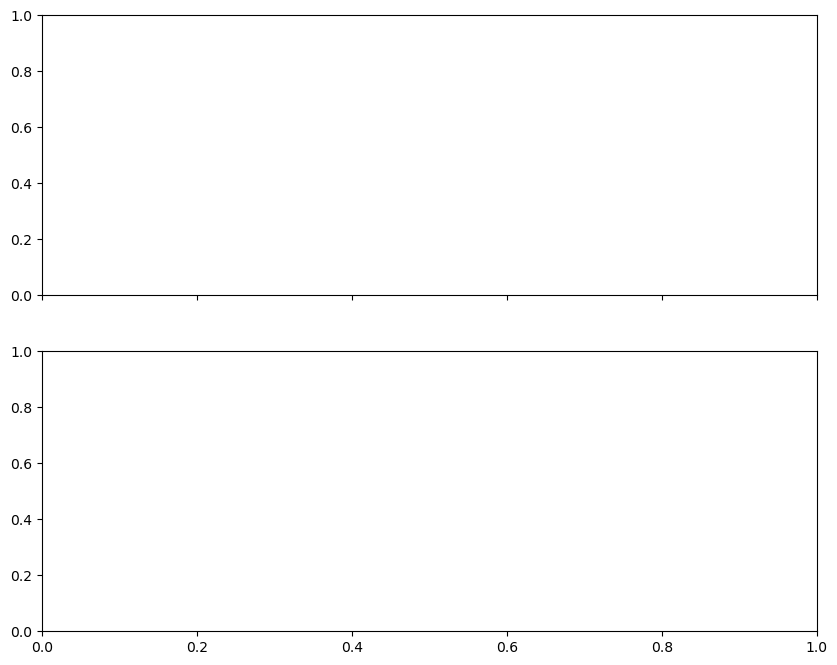

In [62]:
###Use plt.subplots in order to give the layout of each graphic.

fig,axes=plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))


Add titles, axis labels, and use `fig.tight_layout()`.

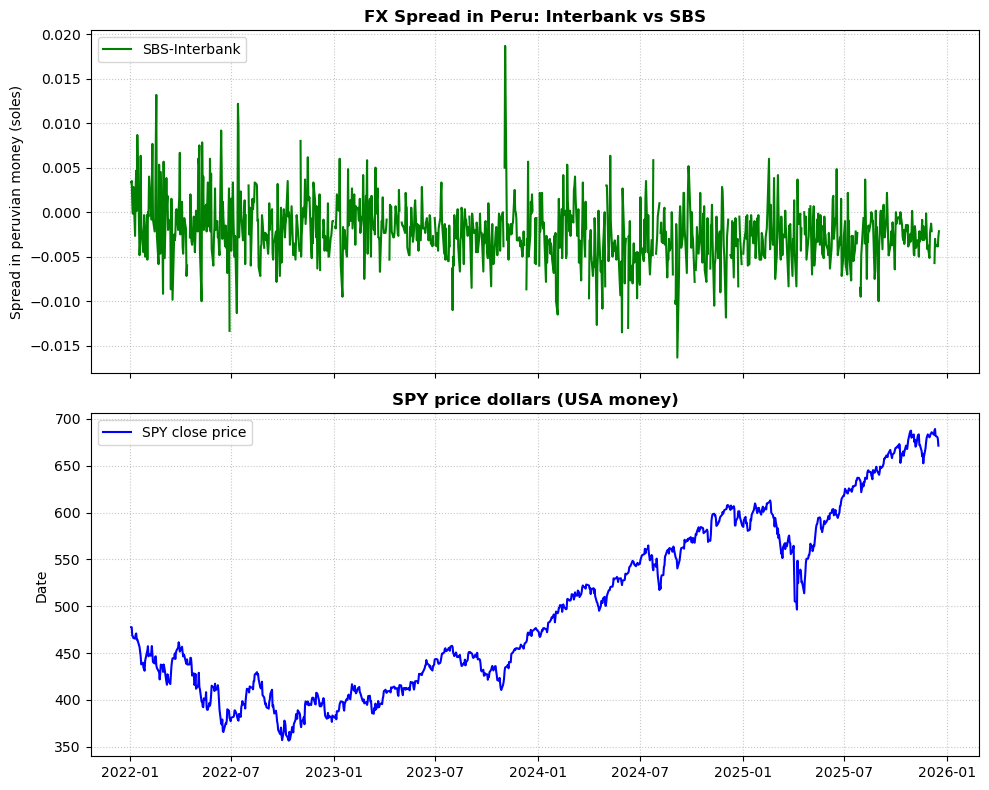

In [63]:
peru_spread=peru_wide.set_index('date').copy()
peru_spread['fx_spread']=peru_spread['fx_sbs_buy']-peru_spread['fx_interbank_buy']
peru_spread

usa_w=usa.pivot(index="date", columns="ticker", values="close")
spy_close=usa_w['SPY']
spy_close

fig,axes=plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))


###This code will be useful for the graphic 1
###We use set_tile, set_ylabel for the requested text
###We use legend for the position
axes[0].plot(peru_spread.index, peru_spread["fx_spread"], color="green", label="SBS-Interbank")
axes[0].set_title("FX Spread in Peru: Interbank vs SBS", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Spread in peruvian money (soles)")
axes[0].grid(True, linestyle=":", alpha=0.7)
axes[0].legend(loc="upper left")

axes[1].plot(spy_close.index, spy_close, color="blue", label="SPY close price")
axes[1].set_title("SPY price dollars (USA money)", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Date")
axes[1].grid(True, linestyle=":", alpha=0.7)
axes[1].legend(loc="upper left")

fig.tight_layout()

plt.show()


### Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

**Tasks**
1. Find the date with the largest `abs(ret)` for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

1. Find the date with the largest `abs(ret)` for SPY.

In [64]:
##This is a filter that gets the ticker named 'SPY' from the data.
spy_ret=usa[usa["ticker"]=="SPY"].set_index("date")["ret"].dropna()
###idxmax() is a betther method than max() due to is using specifically forthe date associated with the highest price
extreme_data=spy_ret.abs().idxmax()
extreme_value=spy_ret.loc[extreme_data]

2. Plot SPY returns over time.

<Axes: xlabel='date', ylabel='Return of each SPY day'>

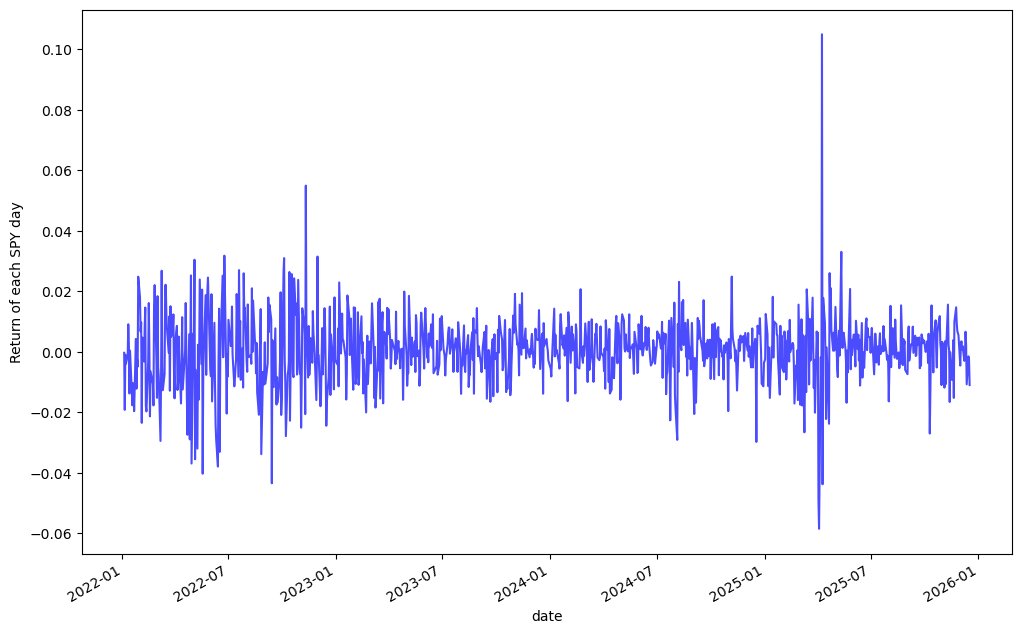

In [65]:
plt.figure(figsize=(12,8))
spy_ret.plot(color="blue", alpha=0.7, ylabel="Return of each SPY day")

3. Add an annotation at the extreme point (arrow + text).

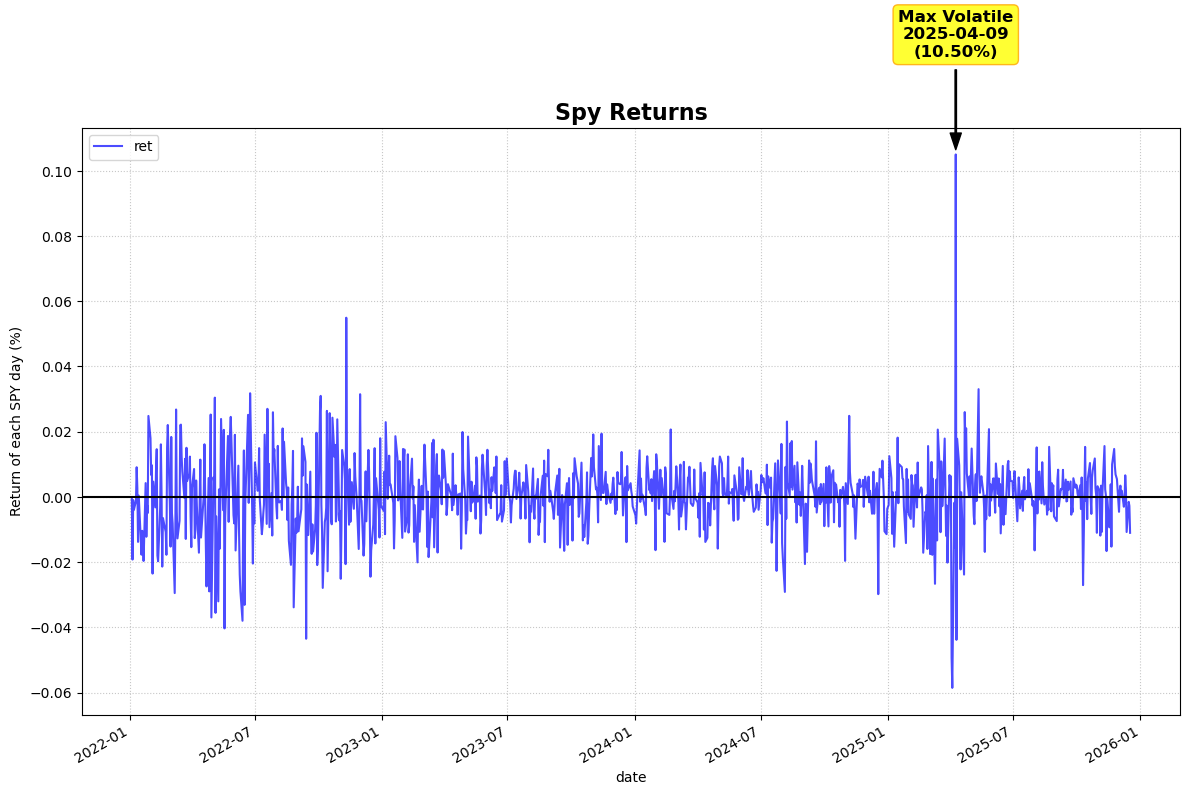

In [66]:
plt.figure(figsize=(12,8))
spy_ret.plot(color="blue", alpha=0.7, ylabel="Return of each SPY day (%)")


###Arrows allow us know where is the max volatile
###First one we put the text
###Then, we use xy to use that variables
###Furthermore, we could change the fontsize and fontweight, meanwhile the arrowprops change our format 
plt.annotate(
    f'Max Volatile\n{extreme_data.date()}\n({extreme_value:.2%})',
    xy=(extreme_data, extreme_value),
    xytext=(extreme_data, extreme_value+0.03 if extreme_value>0 else extreme_value-0.04),
    arrowprops=dict(facecolor="black", shrink=0.05, width=1, headwidth=8),
    ha='center',
    fontsize=12,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="orange", lw=1, alpha=0.8)
)
###Then, for style, we add some plt methods.
plt.title("Spy Returns", fontsize=16, fontweight="bold")
plt.axhline(color="black")
plt.tight_layout()
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend(loc="upper left")

### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [67]:
import os as image
import matplotlib.pyplot as plt

###Create a folder figures through a conditional verifying the existence:
folder="figures"

if not image.path.exists(folder):
    image.makedirs(folder)
    print(f'Created directory: {image}')

###Save the subplot figure as Figure/lecture4II_fx_spy.png
fig.savefig('figures/lecture4II_fx_spy.png', dpi=150, bbox_inches='tight')

####Confirm the file

file_path="figures/lecture4II_fx_spy.png"

if image.path.exists(file_path):
    print(f"File confirmed at: {file_path}")
else:
    print("Warning: File not found")


File confirmed at: figures/lecture4II_fx_spy.png


## 4) Statistics 
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

In [68]:
# ===============================
# 4.1 Summary statistics (returns)
# ===============================

# Wide daily returns table
usa_wide_ret = (
    usa.pivot(index="date", columns="ticker", values="ret")
        .sort_index()
)

# Keep only required assets
usa_wide_ret = usa_wide_ret[["SPY", "TLT", "GLD"]]

# Summary statistics
stats = pd.DataFrame({
    "mean": usa_wide_ret.mean(),
    "std": usa_wide_ret.std(),
    "skewness": usa_wide_ret.skew(),
    "kurtosis": usa_wide_ret.kurtosis()
})

stats


,mean,std,skewness,kurtosis
ticker,,,,
SPY,0.000408,0.011408,0.370137,9.031124
TLT,-0.000446,0.010441,0.014346,0.372478
GLD,0.000920,0.010029,-0.196324,2.401211


### Exercise 4.2 — 
Run a simple regression of GLD returns on SPY returns:

\[
GLD_t = \alpha + \beta\,SPY_t + \varepsilon_t
\]

**Tasks**
1. Build aligned return vectors (drop missing).
2. Compute \alpha and \beta using the closed-form OLS formulas.
3. Plot the scatter and fitted line.
4. Interpret \beta in 2–3 sentences.

In [69]:
# Align returns and drop missing values
reg_df = usa_wide_ret[["SPY", "GLD"]].dropna()

x = reg_df["SPY"].values
y = reg_df["GLD"].values


In [70]:
beta = np.cov(x, y, ddof=1)[0, 1] / np.var(x, ddof=1)
alpha = y.mean() - beta * x.mean()

alpha, beta


(0.0008789945468910875, 0.10180354086179293)

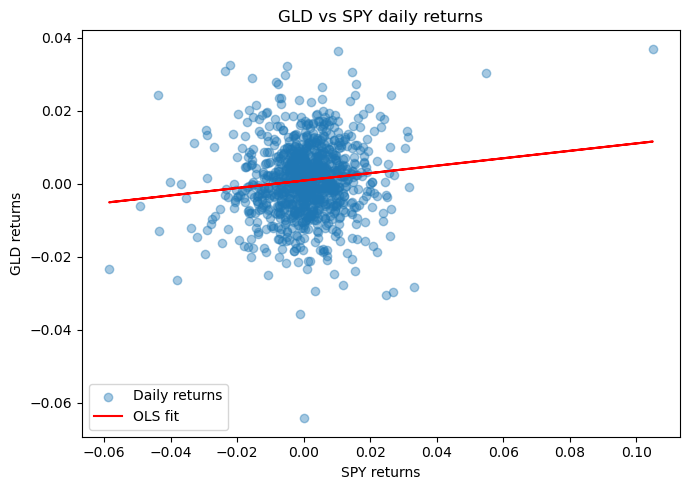

In [71]:
plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.4, label="Daily returns")
plt.plot(x, alpha + beta * x, color="red", label="OLS fit")
plt.xlabel("SPY returns")
plt.ylabel("GLD returns")
plt.title("GLD vs SPY daily returns")
plt.legend()
plt.tight_layout()
plt.show()


The coefficient of \beta = 0.10 implies that an increase of 1% in SPY daily returns (0.01 in decimal terms) is associated with an increase of about 0.1% in GLD daily returns (0.001 in decimal terms). This shows that gold has a weak positive exposure to SPY daily returns. In other words, gold has a low exposure to the stock market. It has a relative independent behavior against the movements of the stock market.

## 5) Risk and Uncertainty 

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

In [72]:
ret_6040 = usa_wide_ret[["SPY", "TLT"]].dropna()


In [73]:
ret_6040["portfolio"] = 0.6 * ret_6040["SPY"] + 0.4 * ret_6040["TLT"]


In [74]:
VaR_95 = np.percentile(ret_6040["portfolio"], 5)
VaR_95


-0.013703131391403734

In [75]:
CVaR_95 = ret_6040.loc[
    ret_6040["portfolio"] <= VaR_95, "portfolio"
].mean()

CVaR_95


-0.018592606080486598

## 6) References

- BCRPData API (CSV endpoint): BCRP statistical series API for downloading time series
- BCRP series catalog: codes for FX (interbank/SBS) and commodity reference prices
- yfinance: Python wrapper to access historical market data from Yahoo Finance